# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.  


Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Для начала, импортируем необходимые библиотеки.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Зафиксируем случайное состояние в константе.

In [2]:
RS = 322

Запишем в переменную `data` данные из файла `labels.csv`.

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')

Выведем размер файла:

In [4]:
data.shape

(7591, 2)

Выведем информацию о датафрейме методом `info()`.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В данном датафрейме есть два столбца: в первом столбце (`'file_name'`) хранится название файла, а во втором (`'real_age'`) - возраст человека на файле с названием из столбца `'file_name'`.

Выведем информацию о столбце `'real_age'` методом `describe()`.

In [6]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Можно увидеть, что в данных встречаются фотографии людей от 1 до 100 лет. Построим гистограмму для возраста с параметром `bins = 100`.

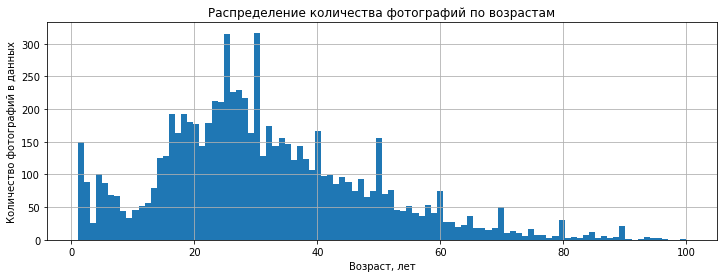

In [7]:
data['real_age'].hist(bins=100, figsize=(12, 4))
plt.title('Распределение количества фотографий по возрастам')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество фотографий в данных');

В выборке больше всего людей в возрасте от 16 до 40 лет.

Создадим загрузчик данных для вывода фотографий на экран. Для этого воспользуемся инструментом `ImageDataGenerator`.

In [8]:
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RS)

Found 7591 validated image filenames.


Напечатаем на экране несколько фотографий из данных:

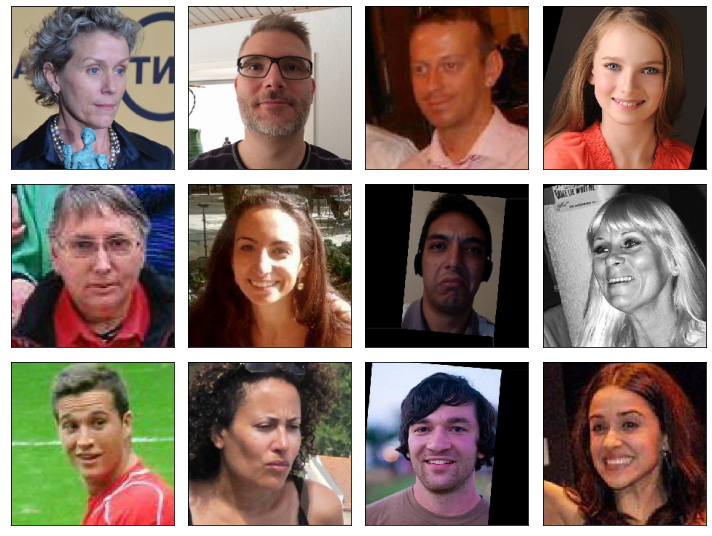

In [9]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<font size="4"> **Вывод по первому разделу** <font>

В выборке предоставленной для обучения модели не очень много фотографий - всего 7591. Чаще всего встречаются фотографии молодых людей от 16 до 40 лет. Сами фотографии не очень хорошего качества, некоторые из них низкого разрешения, с разными ракурсами. Есть немного повёрнутые фотографии, люди на них занимают не всю область фото.  

## Обучение модели

Для решения задачи воспользуемся нейросетью `ResNet50` и добавим к ней один слой пулинга, а также финальный полносвязный слой с функцией активации SoftMax. Обучим сеть и проверим на валидационных данных. Перед обучением аугментируем фотографии, добавив отражение по горизонтали параметром `horizontal_flip=True`. Целевой метрикой будет являться MAE. Для определения изначальных весов будем использовать предзагруженные веса `imagenet`. В параметре `weights` укажем их путь.

<font size="4"> **Код модели** <font>

```python

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import numpy as np
import pandas as pd


RS = 322


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=RS)
    
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=RS)
    
    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data) 
    if validation_steps is None: 
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

<font size="4"> **Вывод модели** <font>

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 52s - loss: 237.2769 - mae: 10.9671 - val_loss: 278.6600 - val_mae: 13.0723
Epoch 2/10
356/356 - 43s - loss: 88.2629 - mae: 7.0728 - val_loss: 164.7073 - val_mae: 10.2501
Epoch 3/10
356/356 - 42s - loss: 58.6912 - mae: 5.8016 - val_loss: 86.5358 - val_mae: 7.0836
Epoch 4/10
356/356 - 42s - loss: 43.6152 - mae: 5.0170 - val_loss: 75.7600 - val_mae: 6.7120
Epoch 5/10
356/356 - 42s - loss: 33.3587 - mae: 4.3751 - val_loss: 75.7710 - val_mae: 6.6930
Epoch 6/10
356/356 - 43s - loss: 25.7176 - mae: 3.8348 - val_loss: 63.7430 - val_mae: 5.9284
Epoch 7/10
356/356 - 43s - loss: 19.3788 - mae: 3.3566 - val_loss: 79.4417 - val_mae: 6.5708
Epoch 8/10
356/356 - 42s - loss: 18.8707 - mae: 3.2664 - val_loss: 69.5416 - val_mae: 6.4355
Epoch 9/10
356/356 - 41s - loss: 16.2759 - mae: 3.0348 - val_loss: 65.0241 - val_mae: 6.0321
Epoch 10/10
356/356 - 39s - loss: 13.8746 - mae: 2.8115 - val_loss: 65.1240 - val_mae: 5.9980

119/119 - 9s - loss: 65.1240 - mae: 5.9980
Test MAE: 5.9980

```

## Анализ обученной модели

В ходе работы над проектом была разработана модель, определяющая возраст людей по фото. Метрика MAE должна была быть ниже 8, а на итоговой модели за 10 эпох обучения она достигла 5.998. При дальнейшем обучении, возможно, получится улучшить метрику, так как модель не начала переобучаться. Это хороший результат, так как даже человек не всегда сможет определить возраст другого человека по фото с такой точностью.